## 1. Introduction

### Hypothesis:

1. **Vehicle Distribution vs. Air Quality**:  
*Hypothesis*: Higher concentrations of private cars are positively correlated with increased levels of air pollution.

   
2. **Traffic Congestion vs. Air Quality**:  
*Hypothesis*: Areas with higher levels of traffic congestion (measured by traffic flow or vehicle counts) exhibit worse air quality compared to less congested areas.


Research Question:

In [29]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import json
from collections import defaultdict
import seaborn as sns
import ast
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


## 2. Data collection & Preprocessing

## 3. Exploratory Data Analysis (EDA)

### 3.1 Road Map

In [17]:
#with open('data/1/traffic_flow.json', 'r') as file:
with open('/Users/zikun/IS5126-Grp-hw/data/traffic_flow.json', 'r') as file:
    tf_flow = json.load(file)['Value']
    


linkID_set = set()
for record in tf_flow:
    link_id = record["LinkID"]
    linkID_set.add(link_id)
# print(len(linkID_set))  # 1312

# road_pos stores the longitude and latitude of its central position.
road_pos = []
for linkID in linkID_set:
    for record in tf_flow:
        if record['LinkID'] == linkID:
            avg_Lon = (float(record['StartLon']) + float(record['EndLon'])) / 2
            avg_Lat = (float(record['StartLat']) + float(record['EndLat'])) / 2
            road_pos.append([avg_Lon, avg_Lat])
            break

In [18]:
len(road_pos)

1312

In [19]:
road_df = pd.DataFrame(road_pos)
road_df.columns = ['Longitude', 'Latitude']
road_df['LinkID'] = list(linkID_set)
road_df

Longitude  Latitude     LinkID
0     103.645273  1.337490  103071622
1     103.901735  1.332431  103077343
2     103.855178  1.329146  104008771
3     103.745652  1.325365  103100183
4     103.733811  1.311407  103076970
...          ...       ...        ...
1307  103.836940  1.377593  103116758
1308  103.785968  1.354641  103092351
1309  103.971121  1.323263  103024888
1310  103.954214  1.332992  103091107
1311  103.696237  1.336247  103049422

[1312 rows x 3 columns]

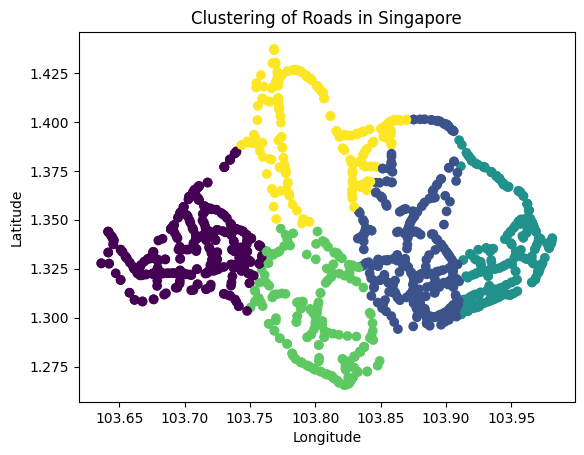

In [20]:
# longitude and latitude range of SG
latitude = [103.38, 104,6]
longitude = [1.09, 1.29]

# initial centers
initial_centers = [
    [1.35735, 103.7],   # 0: west
    [1.35735, 103.94],  # 1: east
    [1.35735, 103.82],  # 2: central
    [1.29587, 103.82],  # 3: south
    [1.41803, 103.82]   # 4: north
]

# Clustering using Kmeans
kmeans = KMeans(n_clusters=5, init=initial_centers, n_init=1)
road_df['Region'] = kmeans.fit_predict(road_df[['Longitude', 'Latitude']])

# Visualization
plt.scatter(road_df['Longitude'], road_df['Latitude'], c=road_df['Region'], cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clustering of Roads in Singapore')
plt.show()

In [21]:
road_df

Longitude  Latitude     LinkID  Region
0     103.645273  1.337490  103071622       0
1     103.901735  1.332431  103077343       1
2     103.855178  1.329146  104008771       1
3     103.745652  1.325365  103100183       0
4     103.733811  1.311407  103076970       0
...          ...       ...        ...     ...
1307  103.836940  1.377593  103116758       4
1308  103.785968  1.354641  103092351       4
1309  103.971121  1.323263  103024888       2
1310  103.954214  1.332992  103091107       2
1311  103.696237  1.336247  103049422       0

[1312 rows x 4 columns]

### 3.2 Polutant
#### 3.2.1 2017-2023

In [22]:
#with open('data/1/pollutant.json', 'r') as file:
with open('/Users/zikun/IS5126-Grp-hw/data/pollutant.json', 'r') as file:
    pollutant = json.load(file)['data']['items'][0]['readings']
pollutant_df = pd.DataFrame(pollutant).T
# Concentration is measured in micrograms per cubic metre 
pollutant_df.sort_index()

pollutant_df_index = pollutant_df[pollutant_df.index.str.endswith('index')]
pollutant_df_index

west  east  central  south  north
o3_sub_index       2     4        4      2      2
pm10_sub_index    19    17       21     15     16
so2_sub_index      5     3        2      2      1
pm25_sub_index    48    42       42     34     34
co_sub_index       6     5        6      3      4

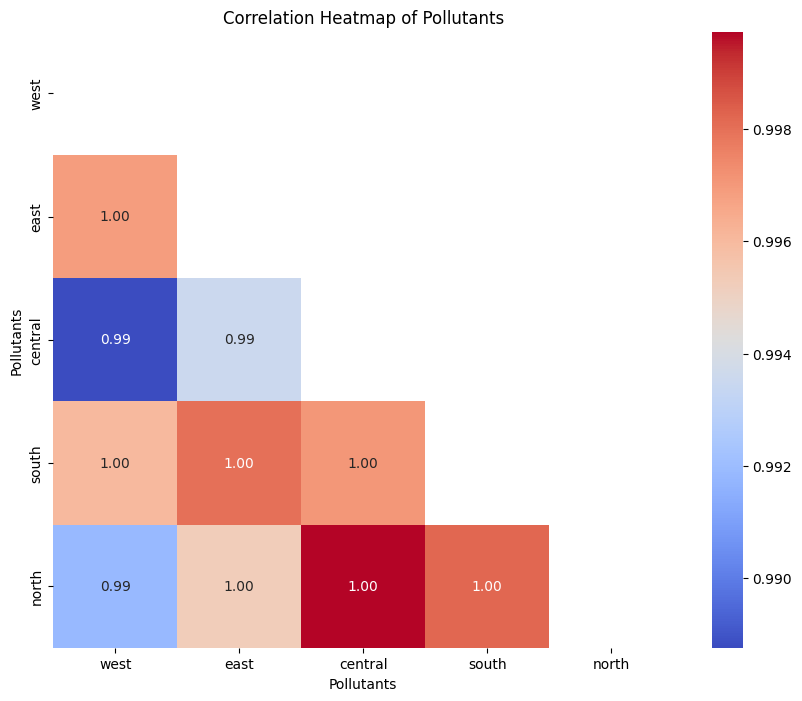

In [23]:
corr_matrix = pollutant_df_index.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f')

# 添加标题和轴标签
plt.title('Correlation Heatmap of Pollutants')
plt.xlabel('Pollutants')
plt.ylabel('Pollutants')

# 显示图形
plt.show()

In [24]:
pollutant_df_index.T.corr()

o3_sub_index  pm10_sub_index  so2_sub_index  pm25_sub_index  \
o3_sub_index        1.000000        0.530669      -0.060193        0.304290   
pm10_sub_index      0.530669        1.000000       0.355931        0.726648   
so2_sub_index      -0.060193        0.355931       1.000000        0.879174   
pm25_sub_index      0.304290        0.726648       0.879174        1.000000   
co_sub_index        0.490098        0.923548       0.581580        0.894792   

                co_sub_index  
o3_sub_index        0.490098  
pm10_sub_index      0.923548  
so2_sub_index       0.581580  
pm25_sub_index      0.894792  
co_sub_index        1.000000

****

In [27]:
#pollutant_df = pd.read_csv("data/res.csv")
pollutant_df = pd.read_csv("/Users/zikun/IS5126-Grp-hw/data/res.csv")
pollutant_df['date'] = pd.to_datetime(pollutant_df['date'])
pollutant_df['year'] = pollutant_df['date'].dt.year
# 定义转换函数
def safe_eval(x):
    if pd.isna(x):
        return {}
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return {}
    
columns_to_convert = ['o3_sub_index', 'no2_one_hour_max', 'o3_eight_hour_max', 
                       'psi_twenty_four_hourly', 'pm10_twenty_four_hourly', 'pm10_sub_index',
                       'pm25_twenty_four_hourly', 'pm25_sub_index', 'psi_three_hourly', 'so2_sub_index',
                       'so2_twenty_four_hourly', 'co_eight_hour_max','co_sub_index']
pollutant_df[columns_to_convert] = pollutant_df[columns_to_convert].applymap(safe_eval)
pollutant_df = pollutant_df.drop(columns=['index'])
pollutant_df

/var/folders/xc/8b0sl97x4cg5thx0wp_hc3_40000gn/T/ipykernel_28648/4093035879.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pollutant_df[columns_to_convert] = pollutant_df[columns_to_convert].applymap(safe_eval)


o3_sub_index  \
0     {'west': 13, 'national': 14, 'east': 14, 'cent...   
1     {'west': 7, 'national': 7, 'east': 6, 'central...   
2     {'west': 16, 'national': 16, 'east': 11, 'cent...   
3     {'west': 24, 'national': 24, 'east': 14, 'cent...   
4     {'west': 13, 'national': 15, 'east': 15, 'cent...   
...                                                 ...   
2551  {'west': 5, 'east': 11, 'central': 6, 'south':...   
2552  {'west': 4, 'east': 13, 'central': 5, 'south':...   
2553  {'west': 10, 'east': 17, 'central': 7, 'south'...   
2554  {'west': 2, 'east': 9, 'central': 7, 'south': ...   
2555  {'west': 4, 'east': 5, 'central': 8, 'south': ...   

                                       no2_one_hour_max  \
0     {'west': 4, 'national': 24, 'east': 17, 'centr...   
1     {'west': 21, 'national': 31, 'east': 22, 'cent...   
2     {'west': 12, 'national': 25, 'east': 8, 'centr...   
3     {'west': 21, 'national': 27, 'east': 9, 'centr...   
4     {'west': 11, 'national': 40, 'east': 14, 'cent...   
...                                                 ...   
2551  {'west': 17, 'east': 19, 'central': 45, 'south...   
2552  {'west': 20, 'east': 18, 'central': 39, 'south...   
2553  {'west': 13, 'east': 20, 'central': 36, 'south...   
2554  {'west': 25, 'east': 18, 'central': 33, 'south...   
2555  {'west': 12, 'east': 30, 'central': 23, 'south...   

                                      o3_eight_hour_max  \
0     {'west': 30, 'national': 32, 'east': 32, 'cent...   
1     {'west': 17, 'national': 17, 'east': 15, 'cent...   
2     {'west': 38, 'national': 38, 'east': 26, 'cent...   
3     {'west': 57, 'national': 57, 'east': 32, 'cent...   
4     {'west': 30, 'national': 35, 'east': 35, 'cent...   
...                                                 ...   
2551  {'west': 11, 'east': 26, 'central': 13, 'south...   
2552  {'west': 10, 'east': 31, 'central': 12, 'south...   
2553  {'west': 23, 'east': 39, 'central': 17, 'south...   
2554  {'west': 6, 'east': 21, 'central': 16, 'south'...   
2555  {'west': 9, 'east': 12, 'central': 20, 'south'...   

                                 psi_twenty_four_hourly  \
0     {'west': 33, 'national': 43, 'east': 43, 'cent...   
1     {'west': 29, 'national': 51, 'east': 51, 'cent...   
2     {'west': 28, 'national': 50, 'east': 45, 'cent...   
3     {'west': 24, 'national': 35, 'east': 35, 'cent...   
4     {'west': 24, 'national': 42, 'east': 36, 'cent...   
...                                                 ...   
2551  {'west': 21, 'east': 44, 'central': 30, 'south...   
2552  {'west': 31, 'east': 39, 'central': 35, 'south...   
2553  {'west': 28, 'east': 29, 'central': 40, 'south...   
2554  {'west': 42, 'east': 50, 'central': 50, 'south...   
2555  {'west': 28, 'east': 41, 'central': 42, 'south...   

                                pm10_twenty_four_hourly  \
0     {'west': 17, 'national': 23, 'east': 21, 'cent...   
1     {'west': 18, 'national': 25, 'east': 23, 'cent...   
2     {'west': 15, 'national': 21, 'east': 21, 'cent...   
3     {'west': 12, 'national': 16, 'east': 16, 'cent...   
4     {'west': 14, 'national': 20, 'east': 18, 'cent...   
...                                                 ...   
2551  {'west': 12, 'east': 21, 'central': 20, 'south...   
2552  {'west': 18, 'east': 20, 'central': 24, 'south...   
2553  {'west': 15, 'east': 21, 'central': 21, 'south...   
2554  {'west': 22, 'east': 24, 'central': 29, 'south...   
2555  {'west': 16, 'east': 21, 'central': 24, 'south...   

                                         pm10_sub_index  \
0     {'west': 17, 'national': 23, 'east': 21, 'cent...   
1     {'west': 18, 'national': 25, 'east': 23, 'cent...   
2     {'west': 15, 'national': 21, 'east': 21, 'cent...   
3     {'west': 12, 'national': 16, 'east': 16, 'cent...   
4     {'west': 14, 'national': 20, 'east': 18, 'cent...   
...                                                 ...   
2551  {'west': 12, 'east': 21, 'central': 20, 'south...   
2552  {'west': 18, 'east':

In [28]:
num_empty_dicts = pollutant_df['psi_three_hourly'].apply(lambda x: x == {}).sum()
print(num_empty_dicts)
print(pollutant_df['psi_three_hourly'].count())
''' 
    psi_three_hourly contains too much empty value (2483/2556) -> drop
'''
pollutant_df = pollutant_df.drop(columns=['psi_three_hourly'])

2483
2556


In [29]:
o3_index = pollutant_df['o3_sub_index'].apply(pd.Series)
o3_index_df = pd.concat([pollutant_df['year'], o3_index], axis=1)
o3_index_df

year  west  national  east  central  south  north
0     2017  13.0      14.0  14.0      8.0    7.0   12.0
1     2017   7.0       7.0   6.0      6.0    4.0    6.0
2     2017  16.0      16.0  11.0      6.0    6.0    9.0
3     2017  24.0      24.0  14.0     12.0   14.0   12.0
4     2017  13.0      15.0  15.0      9.0    9.0   10.0
...    ...   ...       ...   ...      ...    ...    ...
2551  2023   5.0       NaN  11.0      6.0    3.0    8.0
2552  2023   4.0       NaN  13.0      5.0    3.0    8.0
2553  2023  10.0       NaN  17.0      7.0    6.0   12.0
2554  2023   2.0       NaN   9.0      7.0    3.0    3.0
2555  2023   4.0       NaN   5.0      8.0    5.0    2.0

[2556 rows x 7 columns]

In [30]:
average_df = o3_index_df.groupby('year').mean().reset_index()
average_df

year       west   national       east    central      south      north
0  2017  17.204986  19.628809  13.434903  13.490305  11.002770  15.376731
1  2018  14.723288  17.684932  11.254795  13.646575  12.345205  14.191781
2  2019   9.175000  14.628571  10.196429  13.571429  10.578571  11.285714
3  2020   9.110497  14.966851  10.621547  13.273481  11.850829  12.488950
4  2021  10.529412  16.414566  11.473389  14.509804  11.761905  14.095238
5  2022   9.513736  16.222527  12.719780  13.673077   7.873626  13.576923
6  2023   8.488532  16.715789  10.838525  14.308508   9.025251  14.981204

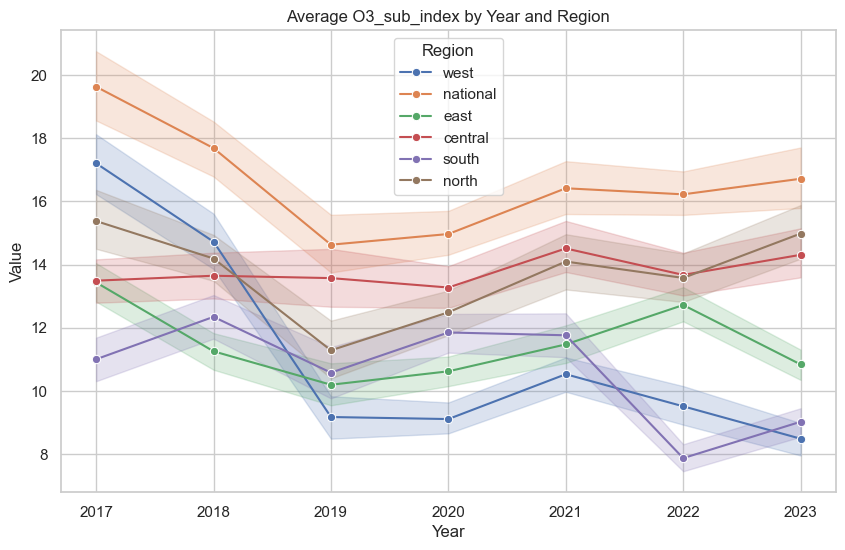

In [31]:
# 将数据转换为长格式
melted_df = o3_index_df.melt(id_vars='year', var_name='region', value_name='value')
# melted_df = o3_indexa_df.melt(id_vars='year', var_name='region', value_name='value')

# 设置绘图风格
sns.set(style="whitegrid")

# 创建一个新的图形和轴
plt.figure(figsize=(10, 6))

# 绘制折线图
sns.lineplot(data=melted_df, x='year', y='value', hue='region', marker='o')

# 设置标题和标签
plt.title('Average O3_sub_index by Year and Region')
plt.xlabel('Year')
plt.ylabel('Value')

# 显示图例
plt.legend(title='Region')

# 显示图形
plt.show()

KeyError: 'psi_three_hourly'

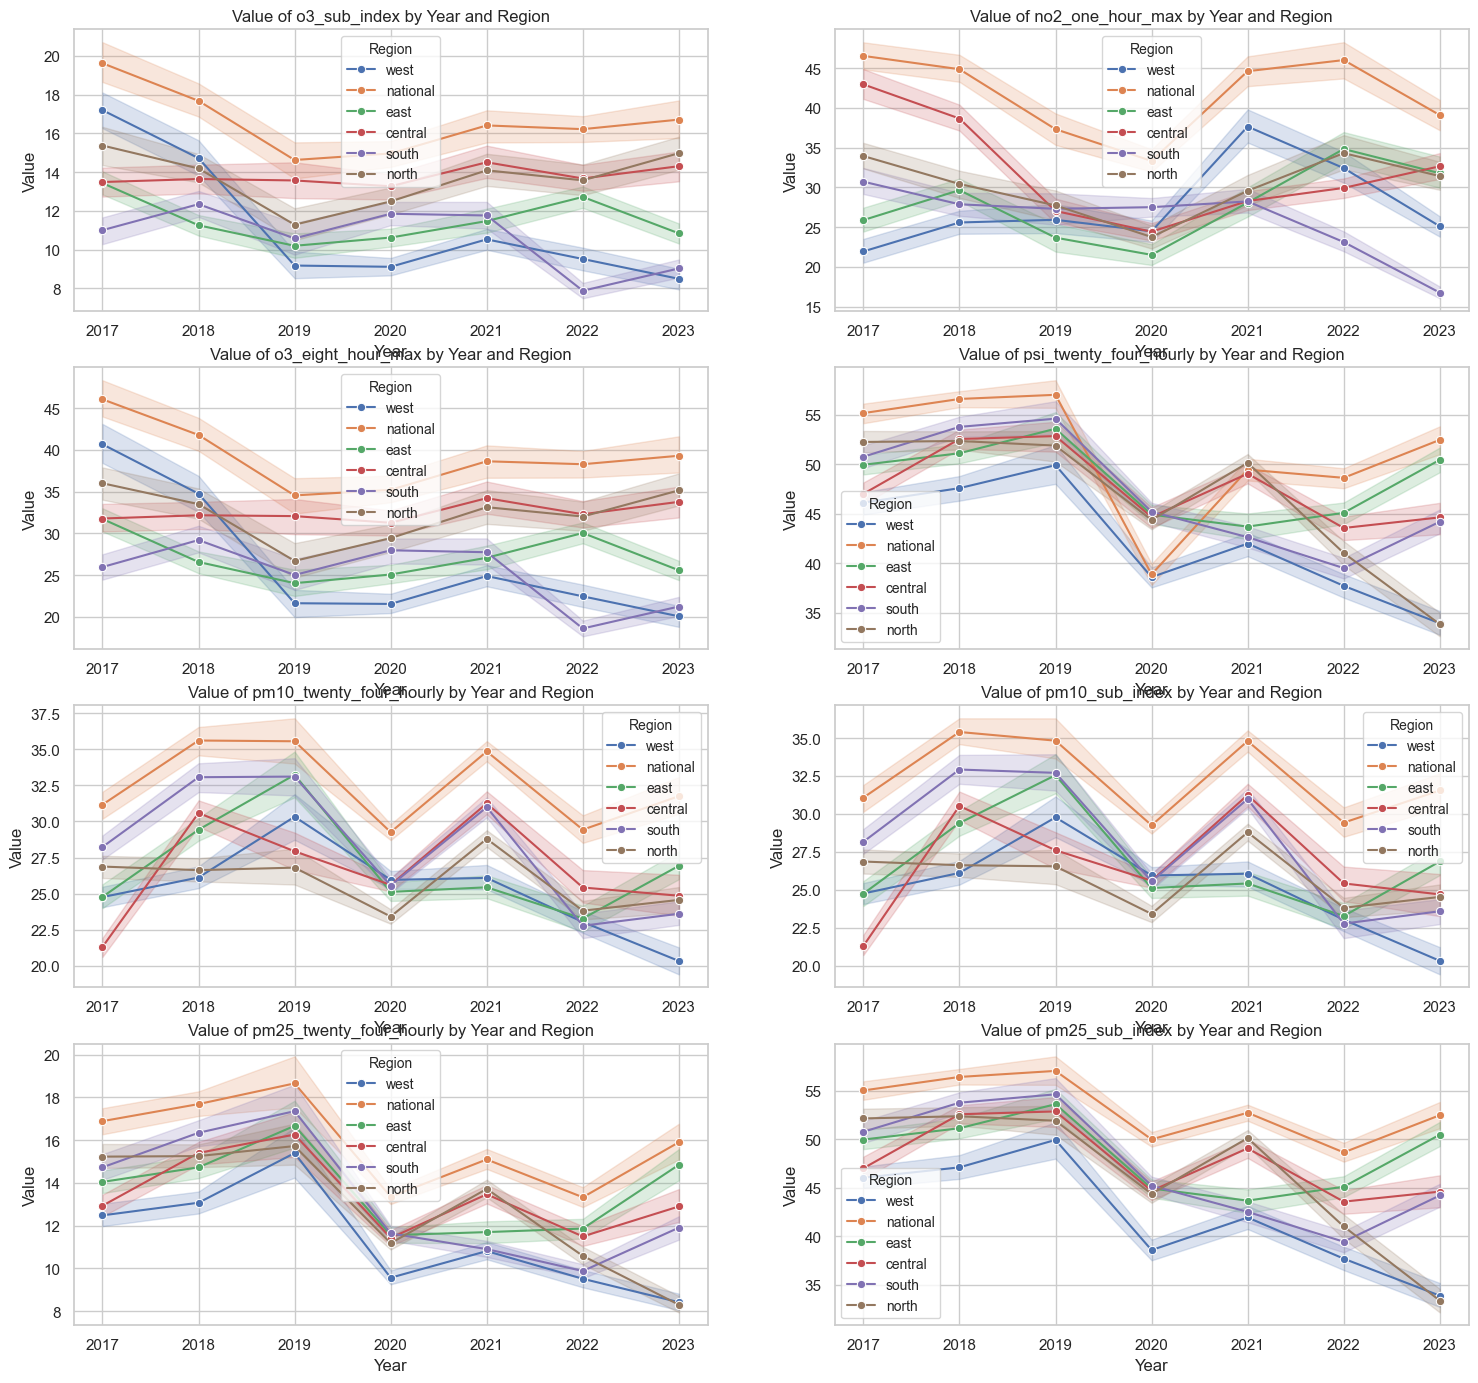

In [32]:
pos = 1
# columns_to_convert.remove('psi_three_hourly')

plt.figure(figsize=(18, 30))

for column in columns_to_convert:
    column_df = pollutant_df[column].apply(pd.Series)   
    column_df = pd.concat([pollutant_df['year'], column_df], axis=1)
    # average_df = column_df.groupby('year').mean().reset_index()
    plt.subplot(7, 2, pos)

    melted_df = column_df.melt(id_vars='year', var_name='region', value_name='value')
    sns.set(style="whitegrid")
    # 绘制折线图
    sns.lineplot(data=melted_df, x='year', y='value', hue='region', marker='o')
    # 设置标题和标签
    plt.title('Value of {} by Year and Region'.format(column))
    plt.legend(title='Region', fontsize='small', title_fontsize='small')
    plt.xlabel('Year')
    plt.ylabel('Value')
    pos = pos + 1

plt.tight_layout()
plt.show()
    

#### 3.2.2 2024-02

In [33]:
pollutant_feb_df = pd.read_csv("/Users/zikun/IS5126-Grp-hw/data/pollutant_202402.csv")
pollutant_feb_df['date'] = pd.to_datetime(pollutant_feb_df['date'])
pollutant_feb_df['day'] = pollutant_feb_df['date'].dt.day
# 定义转换函数
def safe_eval(x):
    if pd.isna(x):
        return {}
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return {}
    
columns_to_convert = ['o3_sub_index', 'no2_one_hour_max', 'o3_eight_hour_max', 
                       'psi_twenty_four_hourly', 'pm10_twenty_four_hourly', 'pm10_sub_index',
                       'pm25_twenty_four_hourly', 'pm25_sub_index', 'so2_sub_index',
                       'so2_twenty_four_hourly', 'co_eight_hour_max','co_sub_index']
pollutant_feb_df[columns_to_convert] = pollutant_feb_df[columns_to_convert].map(safe_eval)
pollutant_feb_df = pollutant_feb_df.drop(columns=['index'])

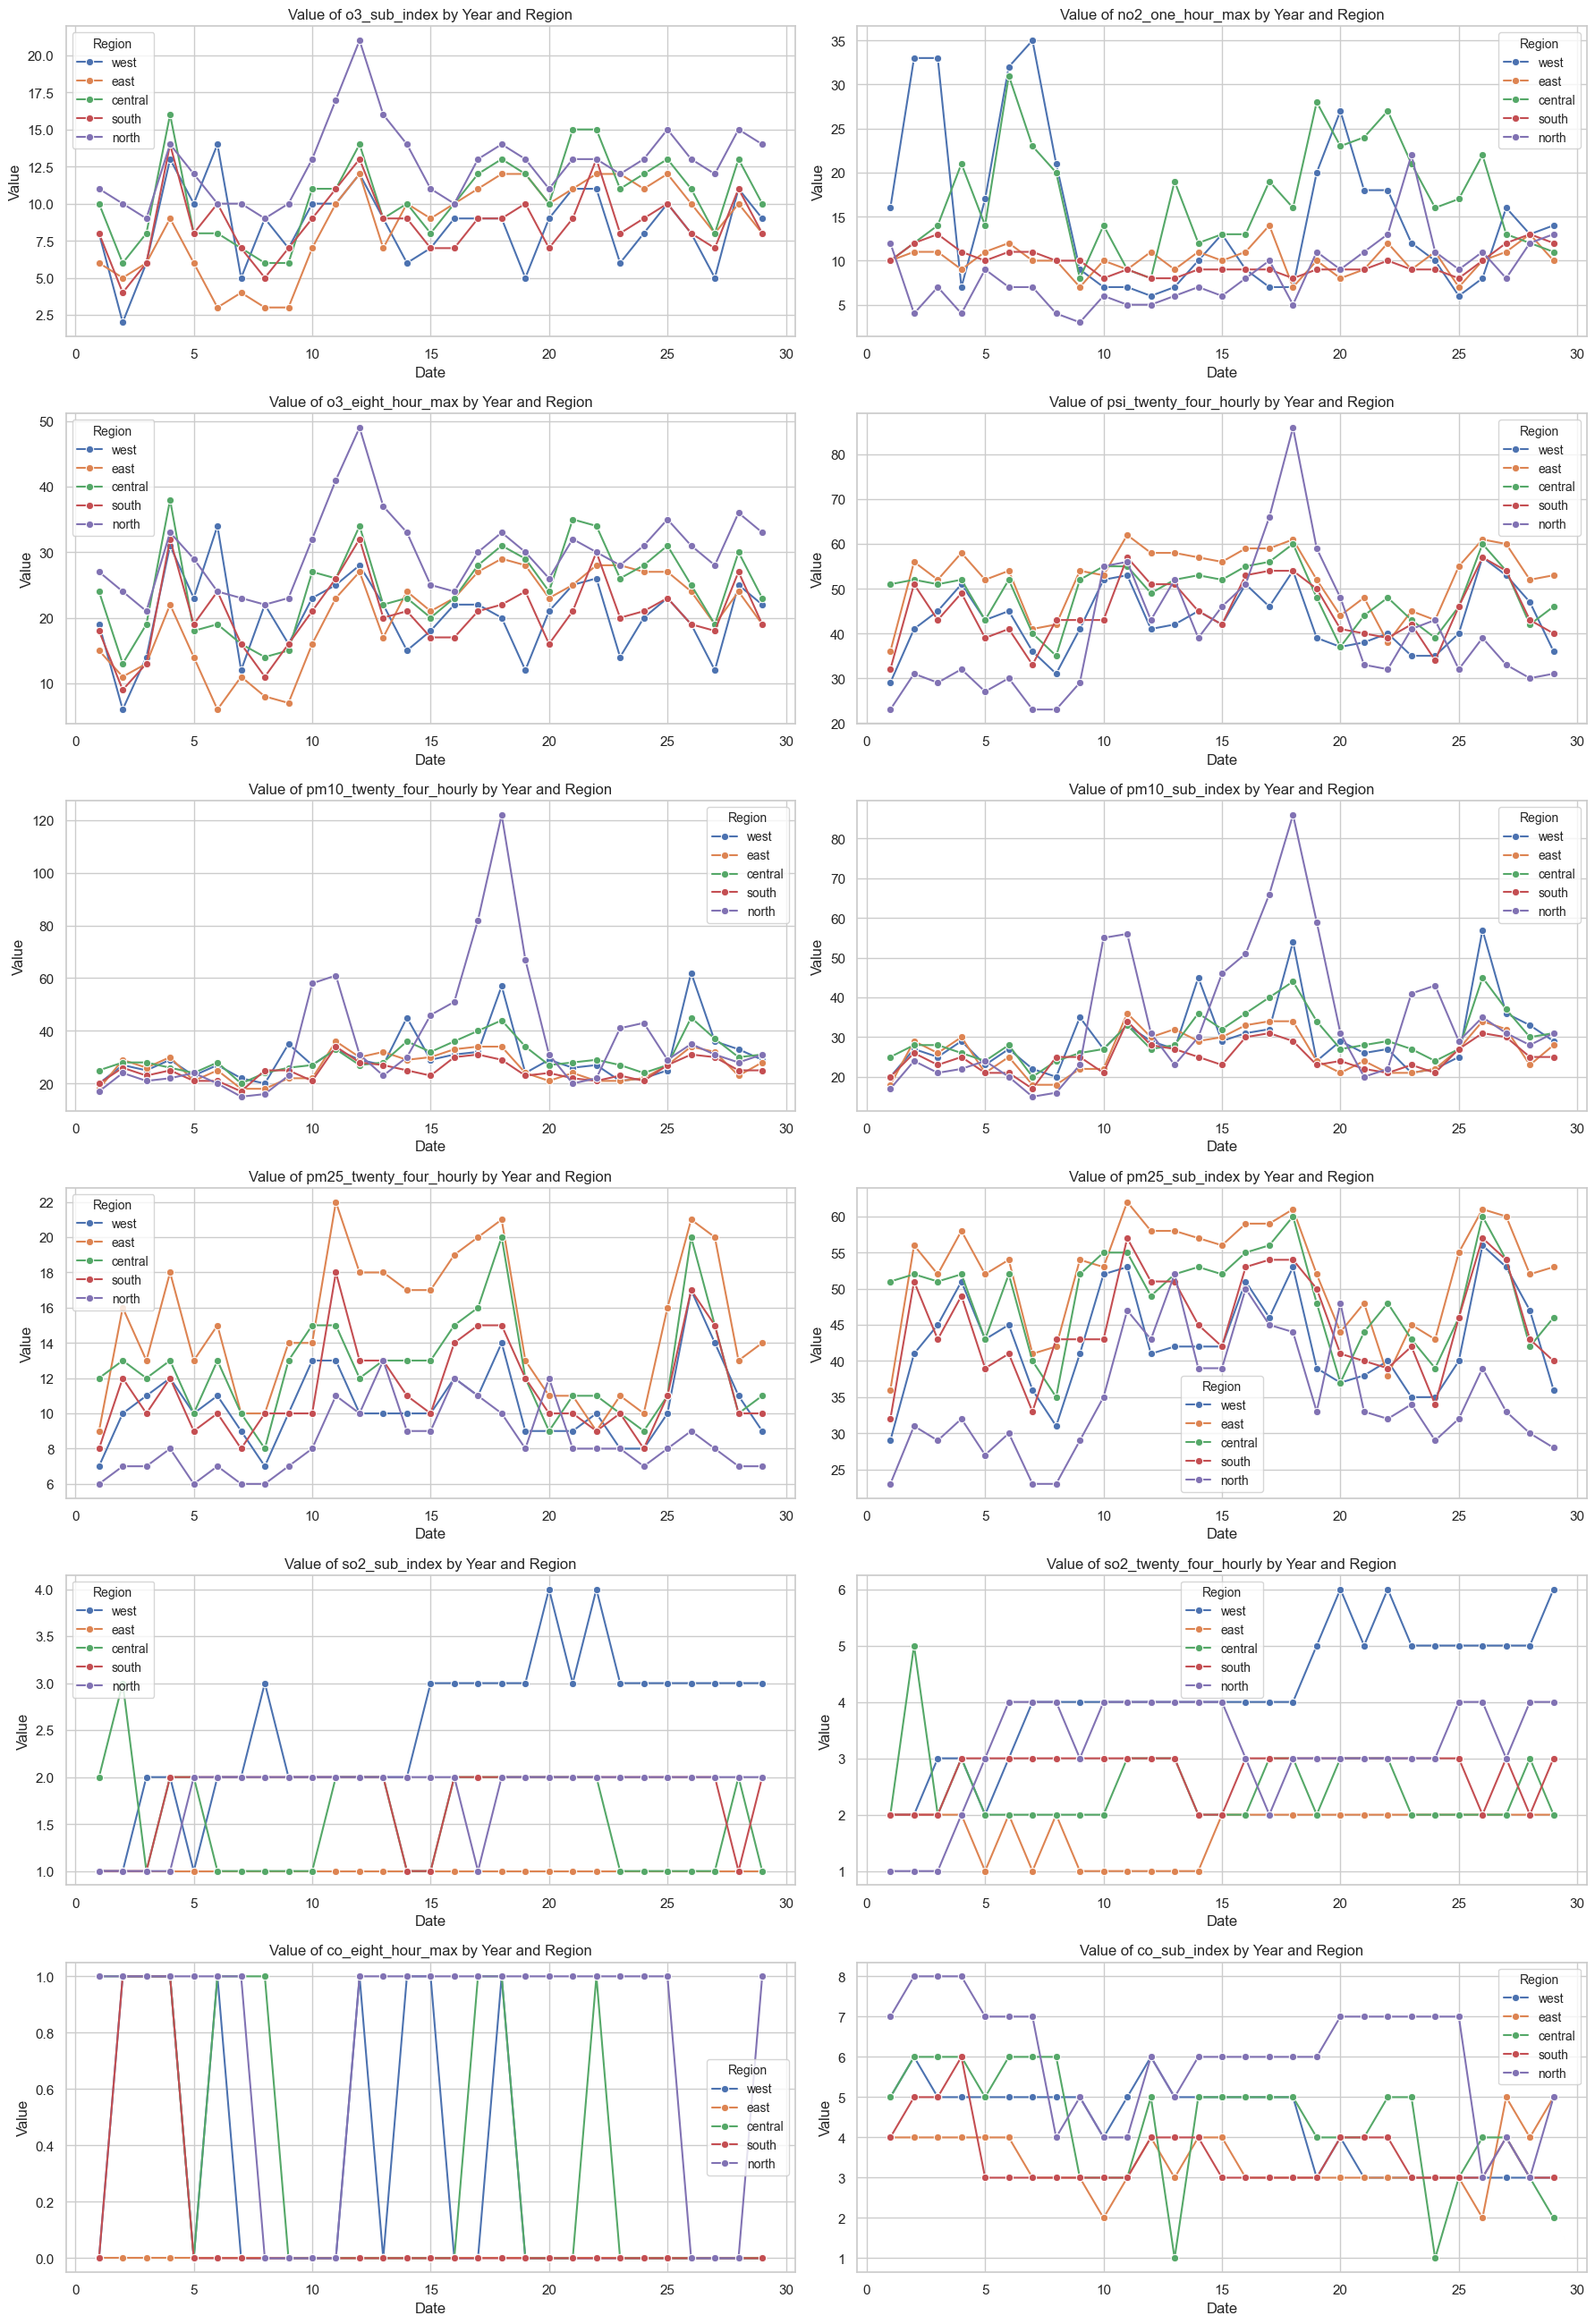

In [34]:
pos = 1
# columns_to_convert.remove('psi_three_hourly')

plt.figure(figsize=(18, 30))

for column in columns_to_convert:
    column_df = pollutant_feb_df[column].apply(pd.Series)   
    column_df = pd.concat([pollutant_feb_df['day'], column_df], axis=1)
    # average_df = column_df.groupby('year').mean().reset_index()
    plt.subplot(7, 2, pos)

    melted_df = column_df.melt(id_vars='day', var_name='region', value_name='value')
    sns.set(style="whitegrid")
    # 绘制折线图
    sns.lineplot(data=melted_df, x='day', y='value', hue='region', marker='o')
    # 设置标题和标签
    plt.title('Value of {} by Year and Region'.format(column))
    plt.legend(title='Region', fontsize='small', title_fontsize='small')
    plt.xlabel('Date')
    plt.ylabel('Value')
    pos = pos + 1

plt.tight_layout()
plt.show()
    

### 3.3 MVP01-1_MVP_by_type

    year  number
0   2005  754992
1   2006  799373
2   2007  851336
3   2008  893803
4   2009  925518
5   2010  945829
6   2011  956704
7   2012  969910
8   2013  974170
9   2014  972037
10  2015  957246
11  2016  956430
12  2017  961842
13  2018  957006
14  2019  973101
15  2020  973990
16  2021  988755
17  2022  995746
18  2023  996732


<Axes: xlabel='year'>

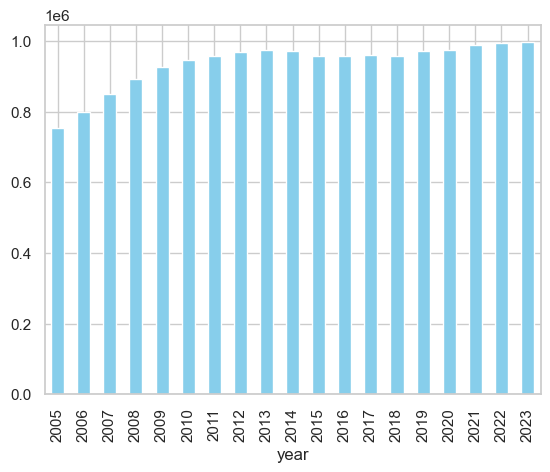

In [35]:
# total amount
MPY_type = pd.read_csv("/Users/zikun/IS5126-Grp-hw/data/MVP01-1_MVP_by_type.csv")
vehicle_population_df = MPY_type.groupby(['year'])['number'].sum().reset_index()
print(vehicle_population_df)
vehicle_population_df.plot(kind='bar', x='year', y='number', color='skyblue', legend=False)


In [36]:
temp = MPY_type[MPY_type['category'] == 'Cars and Station-wagons']
temp = temp.rename(columns={'number': 'Cars and Station-wagons number'})
vehicle_population_df = temp.assign(C=temp['Cars and Station-wagons number'])
vehicle_population_df

year                 category                            type  \
0    2005  Cars and Station-wagons                    Private cars   
1    2006  Cars and Station-wagons                    Private cars   
2    2007  Cars and Station-wagons                    Private cars   
3    2008  Cars and Station-wagons                    Private cars   
4    2009  Cars and Station-wagons                    Private cars   
..    ...                      ...                             ...   
371  2023  Cars and Station-wagons                    Company cars   
372  2023  Cars and Station-wagons                    Tuition cars   
373  2023  Cars and Station-wagons  Private Hire (Self-Drive) cars   
374  2023  Cars and Station-wagons   Private Hire (Chauffeur) cars   
375  2023  Cars and Station-wagons                   Off peak cars   

     Cars and Station-wagons number       C  
0                            401638  401638  
1                            421904  421904  
2                            451745  451745  
3                            476634  476634  
4                            497116  497116  
..                              ...     ...  
371                           35429   35429  
372                             770     770  
373                           28306   28306  
374                           53448   53448  
375                            8736    8736  

[106 rows x 5 columns]

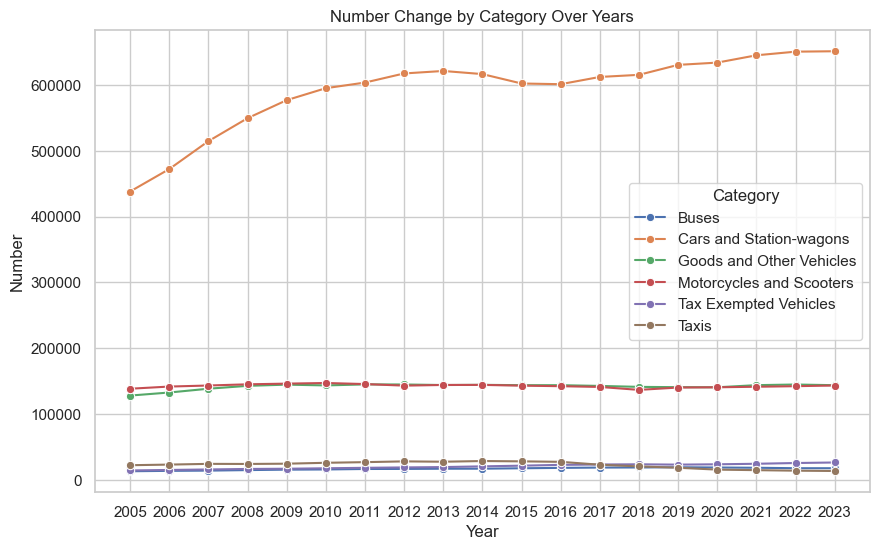

In [37]:
MPY_type = pd.read_csv("/Users/zikun/IS5126-Grp-hw/data/MVP01-1_MVP_by_type.csv")
categoty_df = MPY_type.groupby(['category','year'])['number'].sum().reset_index()

sns.set(style="whitegrid")

# Visualization
plt.figure(figsize=(10, 6))
sns.lineplot(data=categoty_df, x='year', y='number', hue='category', marker='o')

plt.title('Number Change by Category Over Years')
plt.xlabel('Year')
plt.ylabel('Number')
plt.legend(title='Category')
plt.xticks(categoty_df['year'].unique())  
plt.grid(True)


**Focus on the "Cars and Station-wagons" category**

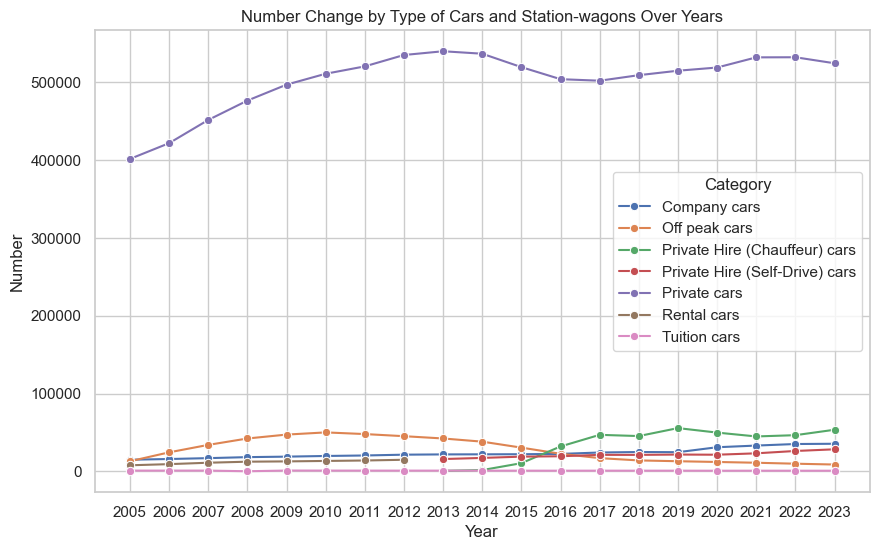

In [38]:
car_df = MPY_type[MPY_type['category'] == 'Cars and Station-wagons'].groupby(['type','year'])['number'].sum().reset_index()

sns.set(style="whitegrid")

# Visualization
plt.figure(figsize=(10, 6))
sns.lineplot(data=car_df, x='year', y='number', hue='type', marker='o')

plt.title('Number Change by Type of Cars and Station-wagons Over Years')
plt.xlabel('Year')
plt.ylabel('Number')
plt.legend(title='Category')
plt.xticks(car_df['year'].unique())  
plt.grid(True)

### 3.4 New_Reg_by_COE

- Category A: Cars with engine capacity up to 1,600cc and Maximum Power Output up to 97kW (130bhp).
- Category B: Cars with engine capacity above 1,600cc or Maximum Power Output above 97kW (130bhp).
- Category C: Goods Vehicles & Buses
- Category C-ETS: Refers to the Early Turnover Scheme (ETS). From 1 April 2021 to 31 March 2025, vehicle owners can deregister their existing Euro 2/3/4 Category C diesel vehicles and register an eligible replacement vehicle within 1 month of deregistration by paying a discounted Prevailing Quota Premium(PQP) under the enhanced ETS.
- Category D: Motorcycles
- Taxis:  Prior to Aug 2012, taxi operators can bid for a new COE or pay Prevailing Quota Premium (PQP) to register a taxi under Category A. The latter is only in the case of a new taxi that replaces a deregistered one within 6 months. From 6 Aug 2012 onwards, all taxis pay for COEs based on the PQP of Category A.
- Vehicles: Exempted From VQS: include scheduled and school buses, emergency vehicles, engineering plants primarily for off-the-road use, diplomatic vehicles and vehicles under the Disabled Person Scheme.

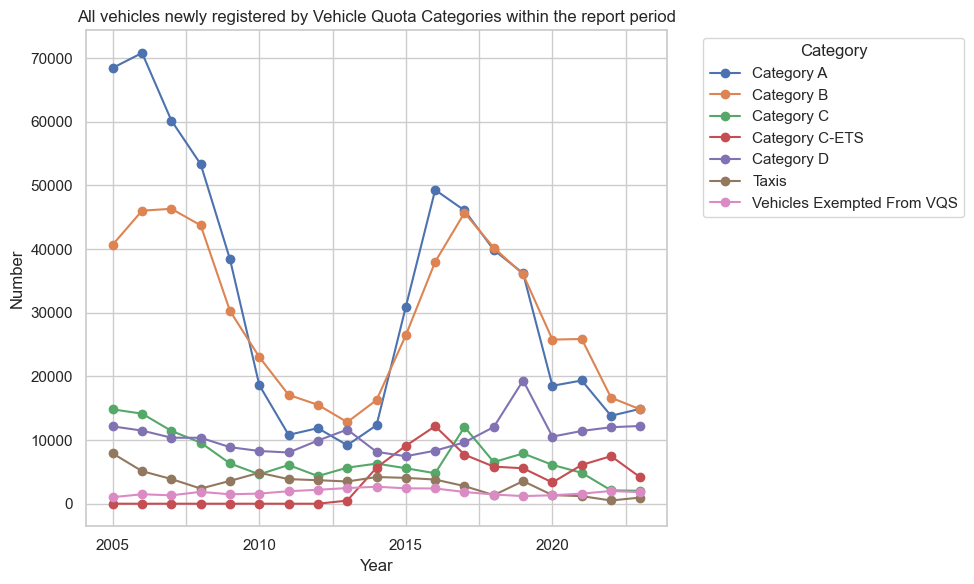

In [39]:
'''
    图中的数据点表示该年新注册的车辆
'''
COE_df = pd.read_csv('/Users/zikun/IS5126-Grp-hw/data/MVP02-1_New_Reg_by_COE.csv')
COE_df['year'] = COE_df['year'].astype(str)
pivot_table = COE_df.pivot_table(index='year', columns='category', values='number', aggfunc='sum')

pivot_table.plot(marker='o', figsize=(10, 6))
plt.title('All vehicles newly registered by Vehicle Quota Categories within the report period')
plt.xlabel('Year')
plt.ylabel('Number')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

### 3.5 Car Make

*【感觉这个有点过于复杂，如果要分析Make和Pollutant的关系的话还要搜集不同车的排放量信息】*

/var/folders/xc/8b0sl97x4cg5thx0wp_hc3_40000gn/T/ipykernel_28648/2722167633.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


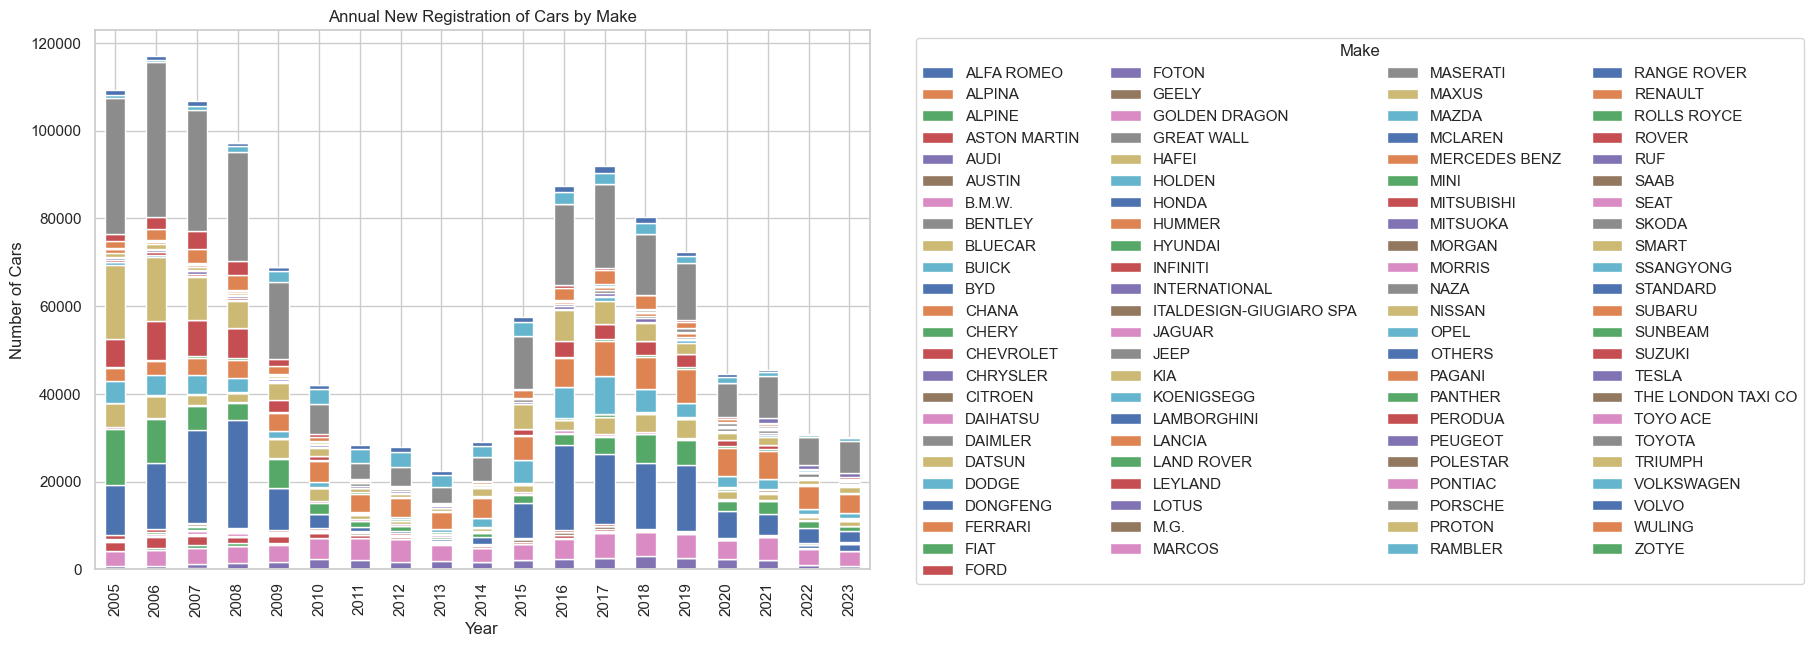

In [40]:
car_make_df = pd.read_csv('/Users/zikun/IS5126-Grp-hw/data/MVP02-2_New_Cars_by_make.csv')
car_make_df = car_make_df.pivot_table(index='year', columns='make', values='number', aggfunc='sum', fill_value=0)

# Visualization
car_make_df.plot(kind='bar', stacked=True, figsize=(10, 7))

plt.title('Annual New Registration of Cars by Make')
plt.xlabel('Year')
plt.ylabel('Number of Cars')
plt.legend(title='Make', bbox_to_anchor=(1.05, 1), ncol=4)
plt.tight_layout()
plt.show()

### 3.6 MVP02-2_New_Cars_by_make_type

*感觉这个可以研究一下fuel的影响*

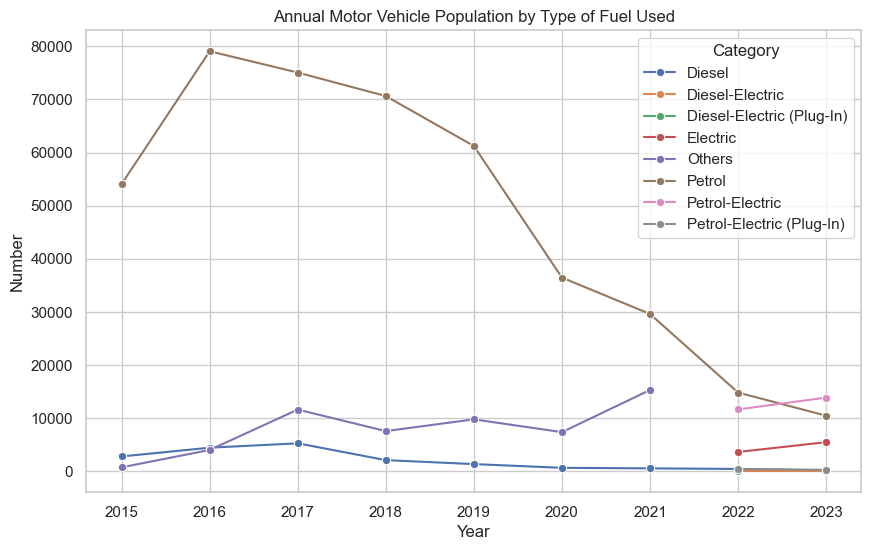

In [41]:
make_type_df = pd.read_csv('/Users/zikun/IS5126-Grp-hw/data/MVP02-2_New_Cars_by_make_type.csv')
make_type_group_df = make_type_df.groupby(['fuel', 'year'])['number'].sum().reset_index()


sns.set(style="whitegrid")

# Visualization
plt.figure(figsize=(10, 6))
sns.lineplot(data=make_type_group_df, x='year', y='number', hue='fuel', marker='o')

plt.title('Annual Motor Vehicle Population by Type of Fuel Used')
plt.xlabel('Year')
plt.ylabel('Number')
plt.legend(title='Category')
plt.xticks(make_type_group_df['year'].unique())  
plt.grid(True)



### 3.7 Traffic Flow

traffic_flow的api好像只能获取2024-02的数据

In [117]:
road_df

Longitude  Latitude     LinkID  Region
0     103.934972  1.374301  103061811       1
1     103.762854  1.373420  103085011       4
2     103.855740  1.329518  103036704       2
3     103.930790  1.335486  103061515       1
4     103.734982  1.348099  103066739       0
...          ...       ...        ...     ...
1307  103.840826  1.328340  103067558       2
1308  103.881565  1.356875  103090667       2
1309  103.676188  1.309376  103076807       0
1310  103.843482  1.326542  103085491       2
1311  103.788899  1.304658  103090311       3

[1312 rows x 4 columns]

In [42]:
with open('/Users/zikun/IS5126-Grp-hw/data/traffic_flow.json', 'r') as file:
    tf_flow = json.load(file)['Value']

tf_flow_df = pd.DataFrame(tf_flow)
tf_flow_df['HourOfDate'] = tf_flow_df['HourOfDate'].astype(int)
tf_flow_df['Volume'] = tf_flow_df['Volume'].astype(int)
# RoadCat means ?
tf_flow_df = tf_flow_df.drop(columns=['StartLon', 'StartLat', 'EndLon', 'EndLat', 'RoadName', 'RoadCat'])

tf_flow_7h_df = tf_flow_df[tf_flow_df['HourOfDate'] == 7]
tf_flow_8h_df = tf_flow_df[tf_flow_df['HourOfDate'] == 8]

tf_flow_7h_df

LinkID        Date  HourOfDate  Volume
0      103000122  01/02/2024           7    3881
2      103000122  02/02/2024           7    4056
4      103000122  03/02/2024           7    2687
6      103000122  04/02/2024           7    1639
8      103000122  05/02/2024           7    3843
...          ...         ...         ...     ...
75491  118001452  25/02/2024           7     999
75493  118001452  26/02/2024           7    2178
75495  118001452  27/02/2024           7    2233
75497  118001452  28/02/2024           7    2171
75499  118001452  29/02/2024           7    2204

[37747 rows x 4 columns]

In [43]:
merged_7h_df = pd.merge(tf_flow_7h_df, road_df, on=['LinkID'], how='left')
merged_7h_df['Date'] = pd.to_datetime(merged_7h_df['Date'], format="%d/%m/%Y")
merged_7h_df['Day'] = merged_7h_df['Date'].dt.day

merged_8h_df = pd.merge(tf_flow_8h_df, road_df, on=['LinkID'], how='left')
merged_8h_df['Date'] = pd.to_datetime(merged_8h_df['Date'], format="%d/%m/%Y")
merged_8h_df['Day'] = merged_8h_df['Date'].dt.day


merged_7h_df

LinkID       Date  HourOfDate  Volume   Longitude  Latitude  Region  \
0      103000122 2024-02-01           7    3881  103.694888  1.351109       0   
1      103000122 2024-02-02           7    4056  103.694888  1.351109       0   
2      103000122 2024-02-03           7    2687  103.694888  1.351109       0   
3      103000122 2024-02-04           7    1639  103.694888  1.351109       0   
4      103000122 2024-02-05           7    3843  103.694888  1.351109       0   
...          ...        ...         ...     ...         ...       ...     ...   
37742  118001452 2024-02-25           7     999  103.703242  1.361749       0   
37743  118001452 2024-02-26           7    2178  103.703242  1.361749       0   
37744  118001452 2024-02-27           7    2233  103.703242  1.361749       0   
37745  118001452 2024-02-28           7    2171  103.703242  1.361749       0   
37746  118001452 2024-02-29           7    2204  103.703242  1.361749       0   

       Day  
0        1  
1        2  
2        3  
3        4  
4        5  
...    ...  
37742   25  
37743   26  
37744   27  
37745   28  
37746   29  

[37747 rows x 8 columns]

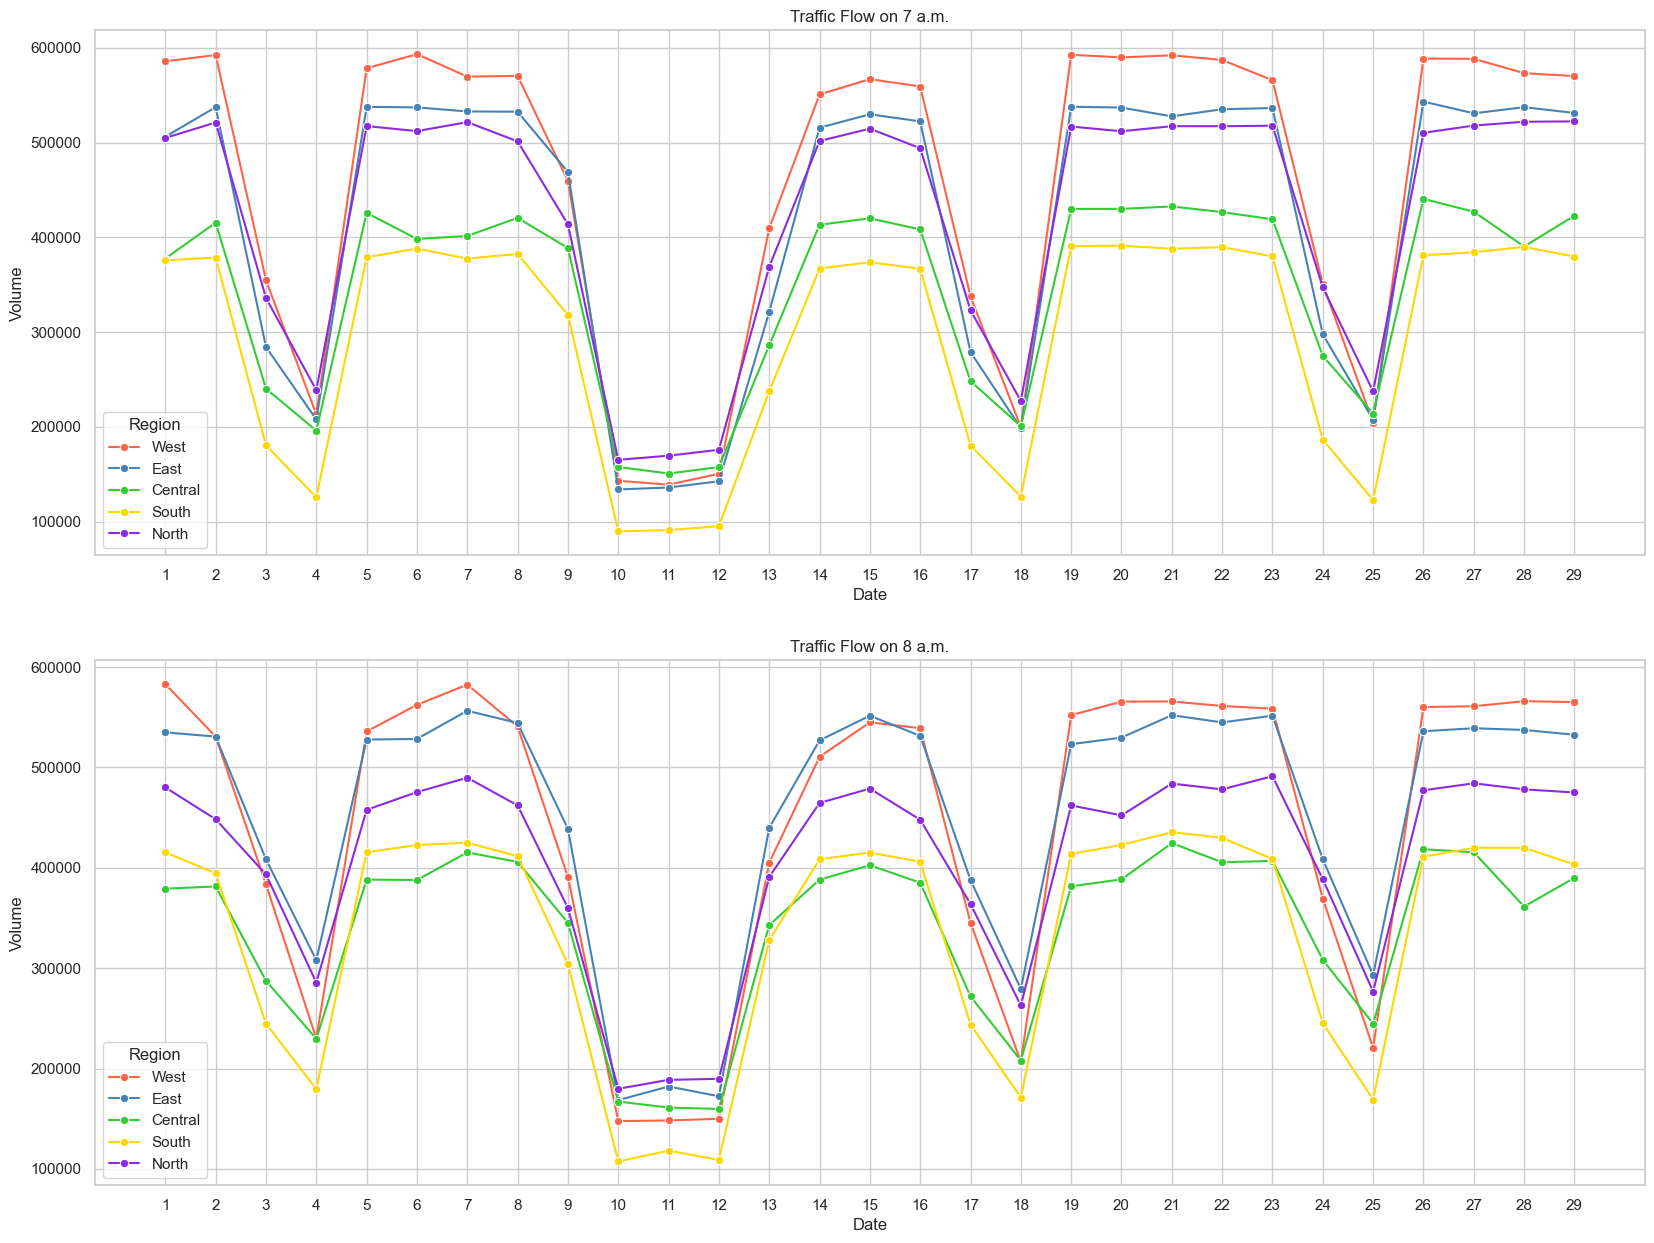

In [44]:
merged_7h_group = merged_7h_df.groupby(['Region', 'Day'])['Volume'].sum().reset_index()
region_mapping = {0: 'West', 1: 'East', 2: 'Central', 3: 'South', 4: 'North'}
merged_7h_group['Region'] = merged_7h_group['Region'].map(region_mapping)


merged_8h_group = merged_8h_df.groupby(['Region', 'Day'])['Volume'].sum().reset_index()
region_mapping = {0: 'West', 1: 'East', 2: 'Central', 3: 'South', 4: 'North'}
merged_8h_group['Region'] = merged_8h_group['Region'].map(region_mapping)


sns.set(style="whitegrid")
custom_palette = ['#FF6347', '#4682B4', '#32CD32', '#FFD700', '#8A2BE2']
# Visualization
plt.figure(figsize=(20,15))
plt.subplot(2, 1, 1)
sns.lineplot(data=merged_7h_group, x='Day', y='Volume', hue='Region', marker='o', palette=custom_palette)

plt.title('Traffic Flow on 7 a.m.')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(merged_7h_group['Day'].unique())  
plt.grid(True)

plt.subplot(2, 1, 2)
sns.lineplot(data=merged_8h_group, x='Day', y='Volume', hue='Region', marker='o', palette=custom_palette)

plt.title('Traffic Flow on 8 a.m.')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(merged_7h_group['Day'].unique())  
plt.grid(True)

plt.show()


In [45]:
merged_8h_group

Region  Day  Volume
0     West    1  583015
1     West    2  530669
2     West    3  383450
3     West    4  229874
4     West    5  535823
..     ...  ...     ...
140  North   25  276719
141  North   26  477215
142  North   27  484179
143  North   28  478162
144  North   29  475061

[145 rows x 3 columns]

### 3.8 Speed Bands

Speed Bands 给的是实时数据

## 4. Data Modelling and Analysis

In [59]:
# Merge vehicle and pollutant data on 'year'
data_merged = pd.merge(vehicle_population_df, average_df, on='year')

print(data_merged.columns)

Index(['year', 'category', 'type', 'Cars and Station-wagons number', 'C',
       'west', 'national', 'east', 'central', 'south', 'north'],
      dtype='object')


['type_Company cars' 'type_Off peak cars'
 'type_Private Hire (Chauffeur) cars'
 'type_Private Hire (Self-Drive) cars' 'type_Private cars'
 'type_Tuition cars']
R-squared: -0.8027463619218074
Coefficients: [ 0.89524673 -0.026521   -0.56222818 -0.07672495  0.00548539 -0.23525799]
Intercept: 16.66776760067636


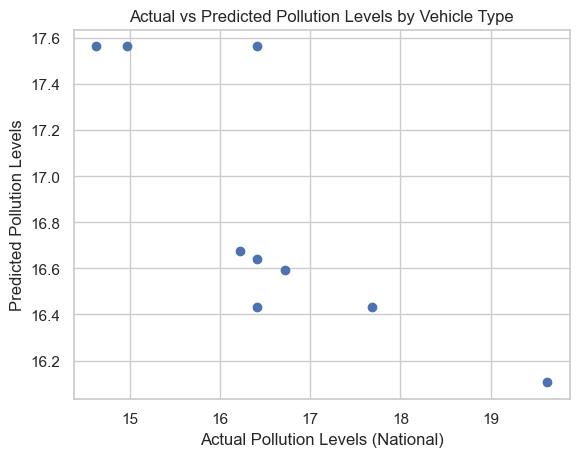

In [65]:
# One-hot encoding for 'type' column
encoder = OneHotEncoder()
type_encoded = encoder.fit_transform(data_merged[['type']]).toarray()
print(encoder.get_feature_names_out(['type']))

type_encoded_df = pd.DataFrame(type_encoded, columns=encoder.get_feature_names_out(['type']))
data_merged_encoded = pd.concat([data_merged, type_encoded_df], axis=1)

# Vehicle types
X = data_merged_encoded[encoder.get_feature_names_out(['type'])]
# Pollution level
Y = data_merged_encoded['national']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

print(f"R-squared: {model.score(X_test, Y_test)}")
print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")

plt.scatter(Y_test, Y_pred)
plt.xlabel('Actual Pollution Levels (National)')
plt.ylabel('Predicted Pollution Levels')
plt.title('Actual vs Predicted Pollution Levels by Vehicle Type')
plt.show()

### Summary:
- **Company cars** have the strongest positive correlation with pollution.
- The rest of the car types show a moderate negative correlation, which could suggest other factors influencing the results.
- The overall fit of the model is poor, as indicated by the negative R-squared value, meaning vehicle types may not be significant predictors of pollution.

## 5. Comparative Analysis

In [25]:
laqn_df = pd.read_csv('data/london/LaqnData.csv')
laqn_df

Site Species   ReadingDateTime  Value   Units Provisional or Ratified
0      CT4      NO  01/01/2015 00:00   12.2  ug m-3                       R
1      CT4      NO  02/01/2015 00:00   54.7  ug m-3                       R
2      CT4      NO  03/01/2015 00:00   68.8  ug m-3                       R
3      CT4      NO  04/01/2015 00:00   66.4  ug m-3                       R
4      CT4      NO  05/01/2015 00:00  120.2  ug m-3                       R
...    ...     ...               ...    ...     ...                     ...
11679  CT4    PM10  26/12/2022 00:00    8.0   ug/m3                       R
11680  CT4    PM10  27/12/2022 00:00    8.0   ug/m3                       R
11681  CT4    PM10  28/12/2022 00:00    5.0   ug/m3                       R
11682  CT4    PM10  29/12/2022 00:00   13.0   ug/m3                       R
11683  CT4    PM10  30/12/2022 00:00    8.0   ug/m3                       R

[11684 rows x 6 columns]

In [26]:
laqn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11684 entries, 0 to 11683
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Site                     11684 non-null  object 
 1   Species                  11684 non-null  object 
 2   ReadingDateTime          11684 non-null  object 
 3   Value                    11194 non-null  float64
 4   Units                    11684 non-null  object 
 5   Provisional or Ratified  11684 non-null  object 
dtypes: float64(1), object(5)
memory usage: 547.8+ KB


In [27]:
print(laqn_df['Site'].unique())
print(laqn_df['Provisional or Ratified'].unique())
laqn_df.drop(columns=['Site', 'Provisional or Ratified'], inplace=True)
laqn_df['year'] = pd.to_datetime(laqn_df['ReadingDateTime'], format='%d/%m/%Y %H:%M').dt.year
laqn_df['Value'] = pd.to_numeric(laqn_df['Value'], errors='coerce')
laqn_df['Value'] = laqn_df.groupby('Species')['Value'].transform(lambda x: x.fillna(x.median()))
laqn_df

['CT4']
['R']


Species   ReadingDateTime  Value   Units  year
0          NO  01/01/2015 00:00   12.2  ug m-3  2015
1          NO  02/01/2015 00:00   54.7  ug m-3  2015
2          NO  03/01/2015 00:00   68.8  ug m-3  2015
3          NO  04/01/2015 00:00   66.4  ug m-3  2015
4          NO  05/01/2015 00:00  120.2  ug m-3  2015
...       ...               ...    ...     ...   ...
11679    PM10  26/12/2022 00:00    8.0   ug/m3  2022
11680    PM10  27/12/2022 00:00    8.0   ug/m3  2022
11681    PM10  28/12/2022 00:00    5.0   ug/m3  2022
11682    PM10  29/12/2022 00:00   13.0   ug/m3  2022
11683    PM10  30/12/2022 00:00    8.0   ug/m3  2022

[11684 rows x 5 columns]

<Figure size 1000x600 with 0 Axes>

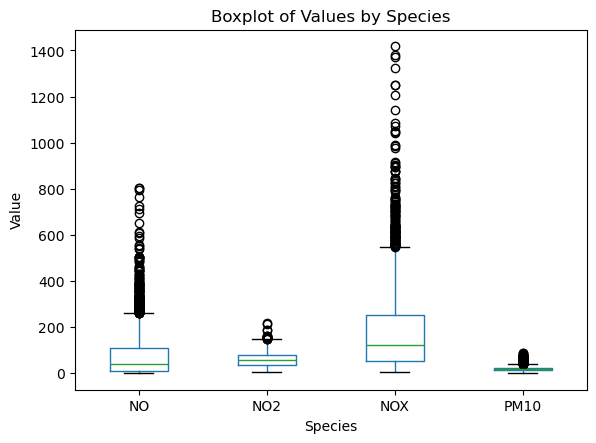

In [28]:
# 绘制箱线图
plt.figure(figsize=(10, 6))
laqn_df.boxplot(column='Value', by='Species', grid=False)
plt.title('Boxplot of Values by Species')
plt.suptitle('')  # 移除默认的标题
plt.xlabel('Species')
plt.ylabel('Value')
plt.show()

R² for NO: 0.37
R² for NO2: 0.63
R² for NOX: 0.42
R² for PM10: 0.43


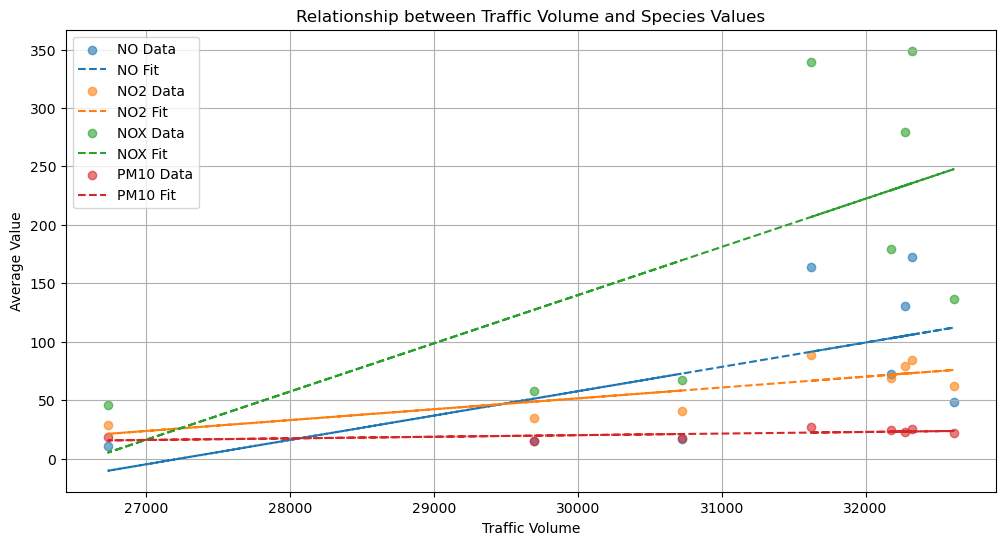

In [31]:
laqn_avg_df = laqn_df.groupby(['year', 'Species'])['Value'].mean().reset_index()
# 添加交通流量数据
london_tf_volumn = [31624, 32321, 32276, 32175, 32612, 26737, 29698, 30721]
years = sorted(laqn_avg_df['year'].unique())

# 添加交通流量到数据框
laqn_avg_df['TrafficVolume'] = laqn_avg_df['year'].map(dict(zip(years, london_tf_volumn)))

species_list = laqn_avg_df['Species'].unique()

# 创建图表
plt.figure(figsize=(12, 6))

# 对每个种类拟合并画图
for species in species_list:
    species_data = laqn_avg_df[laqn_avg_df['Species'] == species]
    
    X = species_data['TrafficVolume'].values.reshape(-1, 1)
    y = species_data['Value'].values
    
    # 拟合线性回归模型
    model = LinearRegression()
    model.fit(X, y)
    
    # 预测
    y_pred = model.predict(X)
    
    r2 = r2_score(y, y_pred)
    print(f'R² for {species}: {r2:.2f}')
    # 绘制散点图和拟合线
    plt.scatter(X, y, label=f'{species} Data', alpha=0.6)
    plt.plot(X, y_pred, label=f'{species} Fit', linestyle='--')

plt.title('Relationship between Traffic Volume and Species Values')
plt.xlabel('Traffic Volume')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()

## 6. Conclusions and Recommendations

## 7. References